In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import numpy as np
import torchtext
from torchtext.data import Iterator, BucketIterator
from torchvision import transforms, utils
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import f1_score as f1
import pandas as pd
import seaborn as sns

In [2]:
batch_size = 300
num_folds = 5

def split_text(text):
    return text.split(' ')

def prepare_sequences():
    tokenizer = split_text # the function above is the function we will be using to tokenize the text
    TEXT = torchtext.data.ReversibleField(sequential=True, tokenize=tokenizer, lower=True)
    LABEL = torchtext.data.Field(sequential=False, use_vocab=False) # sequential and use_vocab=False since no text (binary)
    QID = torchtext.data.Field(sequential=False, use_vocab=False)
    
    train_datafields = [("question_text", TEXT), ("target", LABEL)]
    fold_names = ['train_fold{}.csv'.format(i) for i in range(1,num_folds+1)]
    train_folds = []
    for fold in fold_names:
        train_folds.append(torchtext.data.TabularDataset( 
                # If we had a validation set as well, we would add an additional .splits(...)
                path=fold, # the root directory where the data lies
                format='csv',
                # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
                skip_header=True, 
                fields=train_datafields
                )
            )
    test_datafields = [('qid', QID),("question_text", TEXT)]
    test = torchtext.data.TabularDataset( 
                    path='test.csv',
                    format="csv",
                    skip_header=True,
                    fields=test_datafields
                    )
    return TEXT, LABEL, train_folds, test

TEXT, LABEL, train, test = prepare_sequences()
vec = torchtext.vocab.Vectors('master_v2.txt')
TEXT.build_vocab(*train,test, vectors=vec)

emb_vecs = TEXT.vocab.vectors
for i in range(len(emb_vecs)):
    if len(emb_vecs[i, : ].nonzero()) == 0:
        # std = 0.05 is based on the norm of average GloVE 100-dim word vectors
        torch.nn.init.normal_(emb_vecs[i], mean=0, std=0.05)
       
train_fold_loader = []
for fold in train:
    train_fold_loader.append(BucketIterator(
         fold, # we pass in the datasets we want the iterator to draw data from
         batch_size=batch_size,
         shuffle = True,
         sort_key=lambda x: len(x.question_text), # the BucketIterator needs to be told what function it should use to group the data.
         sort_within_batch=False, # sorting would add bias
         repeat=False 
        )
    )
test_loader = BucketIterator(
         test, # we pass in the datasets we want the iterator to draw data from
         batch_size=batch_size,
         sort_key=lambda x: len(x.question_text), # the BucketIterator needs to be told what function it should use to group the data.
         sort_within_batch=False, # sorting would add bias
         repeat=False 
        )

In [22]:
def validation(loader, test_set, predictions):
    accuracy = 0
    num_batches = 0
    act = np.array([])
    pred = np.array([])
    with torch.no_grad():
        for batch in loader:
            gpu = batch.question_text.to(device).long()
            preds = Attn_bid_lstm_cnn(gpu)
            target = batch.target.numpy()
            preds = preds.cpu().detach().numpy()
            preds = preds >= 0.5
            preds = preds.flatten()
            total_correct = sum(target == preds)

            act = np.concatenate((act, target))
            pred = np.concatenate((pred, preds))

            accuracy += total_correct
            num_batches += 1
            torch.cuda.empty_cache()
            del gpu, target, preds
        count = 0
        for batch in test_set:
            qid = batch.qid
            question = batch.question_text.to(device).long()
            preds = Attn_bid_lstm_cnn(question)
            preds = preds.cpu().detach().numpy()
            for idx, ID in enumerate(qid):
                predictions[ID.item()].append(preds[idx])
            torch.cuda.empty_cache()
            del qid, question, preds
            count+=1
    acc = accuracy / (num_batches * batch_size)
    print('Accuracy ->',acc)
    formula1 = f1(act, pred)
    print('f1 ->',formula1)
    tn,fp,fn,tp = cm(act, pred).ravel()
    print('True positives -> {}\nFalse positives -> {}\nTrue negatives -> {}\nFalse negatives -> {}\n'.format(tp,fp,tn,fn))
    return acc, formula1

def plot():
    plt.scatter([i for i in range(len(accuracy_fold))], f1_fold, label = 'F1 Training set')
    a = 0
    for r in f1_fold:
        a += r
    a /= len(f1_fold)
    plt.plot([i for i in range(len(accuracy_fold))], [a for i in range(len(accuracy_fold))], label = 'Avg fold f1 = {0:.3f}'.format(float(a)))
    plt.legend()
    plt.title('5 Fold Cross-validation F1 score Attention bilstm cnn')
    plt.xlabel('Fold held out')
    plt.ylabel('F1 Score')
    plt.show()

def train_model(batch):
    Attn_bid_lstm_cnn.zero_grad()
    optimizer.zero_grad()
    loss = 0
    
    gpu = batch.question_text.to(device).long()
    target = batch.target.to(device).to(device).float()

    predicted = Attn_bid_lstm_cnn(gpu).view(-1)
    loss = criterion(predicted, target)
    loss.backward()
    optimizer.step()
    return loss.item()

In [4]:
class Attention(nn.Module):
    def __init__(self, batch_size, size):
        super(Attention, self).__init__()
        self.word_weight = nn.Linear(size, size)
        self.tanh = nn.Tanh()
        self.context_weight = nn.Linear(size, 1, bias = False)
        self.softmax = nn.Softmax(dim = 1)
    
    def forward(self, inpt):
        inpt = inpt.permute(1,0,2)
        a = self.word_weight(inpt)
        a = self.tanh(a)
        a = self.context_weight(a)
        a = self.tanh(a)
        a = self.softmax(a)
        inpt = inpt * a
        return torch.sum(inpt, 1)

In [9]:
class bidirec_lstm_cnn_attn(nn.Module): 
    def __init__(self, 
                 input_size, #size of in vector
                 hidden_size,
                 num_layers,
                 num_channels, #num channels
                 kernel_size, #size of kernel
                 pool_size, #size of max pooling kernel
                 dropout
                 ):
        super(bidirec_lstm_cnn_attn, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_channels = num_channels
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.dropout = dropout
        
        self.emb = nn.Embedding(len(TEXT.vocab), self.input_size)
        self.emb.weight = nn.Parameter(TEXT.vocab.vectors)
        
        self.emb_dropout = nn.Dropout2d(dropout)
        self.lstm = nn.LSTM(self.input_size, 
                            self.hidden_size, 
                            num_layers = self.num_layers,
                            dropout = self.dropout,
                            bidirectional = True)
        self.attention = Attention(batch_size, self.hidden_size * 2)
        self.conv = nn.Conv1d(1, 
                              num_channels,
                              kernel_size)
        self.batch_norm = nn.BatchNorm1d(self.num_channels)
        self.pool = nn.MaxPool1d(pool_size)
        self.relu = nn.LeakyReLU()
        # 2 for bi direction
        self.output_size = 2*(self.hidden_size - self.kernel_size)/self.pool_size
        self.output_size = int(self.output_size*self.num_channels+2)
        self.layer = nn.Linear(self.output_size, 1)
        self.sig = nn.Sigmoid()
    
    def forward(self, inpt):
        
        #bid lstm layer
        inpt = self.emb(inpt)
        inpt = self.emb_dropout(inpt)
        batch_size = inpt.shape[1]
        inpt,_ = self.lstm(inpt)
        inpt = self.attention(inpt)
        inpt = inpt.unsqueeze(0)
        inpt = inpt.permute(1,0,2)
        #1D convolutional layer
        inpt = self.conv(inpt)
        inpt = self.relu(inpt)
        inpt = self.batch_norm(inpt)
        inpt = inpt.view(batch_size,-1)
        temp = inpt.size()[1]
        inpt = inpt.view(batch_size, 1,temp)
        inpt = self.pool(inpt)
        inpt = inpt.view(batch_size, -1)
        inpt = self.layer(inpt)
        inpt = self.sig(inpt)
        return inpt

  0%|          | 0/5 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++
Fold -> 0
	Epoch 1/5	AVG loss: 0.11794773057684833	Total loss:410.92989332973957
	Epoch 2/5	AVG loss: 0.0976183981753364	Total loss:340.102499242872
	Epoch 3/5	AVG loss: 0.08368570165736462	Total loss:291.5609845742583
	Epoch 4/5	AVG loss: 0.06993554399458929	Total loss:243.65543527714908
	Epoch 5/5	AVG loss: 0.059658052480483406	Total loss:207.84865484200418
Accuracy -> 0.9550057405281286
f1 -> 0.6155162766202561


 20%|██        | 1/5 [42:33<2:50:12, 2553.20s/it]

True positives -> 9350
False positives -> 4869
True negatives -> 240193
False negatives -> 6812

++++++++++++++++++++++++++++++++++++++++
Fold -> 1
	Epoch 1/5	AVG loss: 0.11780703107342039	Total loss:410.4396962597966
	Epoch 2/5	AVG loss: 0.0979396041544704	Total loss:341.22158087417483
	Epoch 3/5	AVG loss: 0.08341949008807249	Total loss:290.63350346684456
	Epoch 4/5	AVG loss: 0.07004824840334317	Total loss:244.04809743724763
	Epoch 5/5	AVG loss: 0.06021426848524029	Total loss:209.78651140257716
Accuracy -> 0.9544508228090318
f1 -> 0.6294416243654821


 40%|████      | 2/5 [1:23:14<2:05:58, 2519.50s/it]

True positives -> 10044
False positives -> 5708
True negatives -> 239354
False negatives -> 6118

++++++++++++++++++++++++++++++++++++++++
Fold -> 2
	Epoch 1/5	AVG loss: 0.11707947371970225	Total loss:407.90488643944263
	Epoch 2/5	AVG loss: 0.09749163120202335	Total loss:339.66084310784936
	Epoch 3/5	AVG loss: 0.08338282359913676	Total loss:290.50575741939247
	Epoch 4/5	AVG loss: 0.06979359526306939	Total loss:243.16088589653373
	Epoch 5/5	AVG loss: 0.06022861272569245	Total loss:209.8364867363125
Accuracy -> 0.9533830845771144
f1 -> 0.6348526439624746


 60%|██████    | 3/5 [2:05:56<1:24:24, 2532.33s/it]

True positives -> 10523
False positives -> 6466
True negatives -> 238596
False negatives -> 5639

++++++++++++++++++++++++++++++++++++++++
Fold -> 3
	Epoch 1/5	AVG loss: 0.11803852446189088	Total loss:411.24621922522783
	Epoch 2/5	AVG loss: 0.09786064156901035	Total loss:340.9464752264321
	Epoch 3/5	AVG loss: 0.08324990707613211	Total loss:290.0426762532443
	Epoch 4/5	AVG loss: 0.07052120135724972	Total loss:245.69586552865803
	Epoch 5/5	AVG loss: 0.06005347877191262	Total loss:209.22632004134357
Accuracy -> 0.9549751243781095
f1 -> 0.6173437653452059


 80%|████████  | 4/5 [2:46:36<41:44, 2504.68s/it]  

True positives -> 9429
False positives -> 4956
True negatives -> 240106
False negatives -> 6733

++++++++++++++++++++++++++++++++++++++++
Fold -> 4
	Epoch 1/5	AVG loss: 0.11838787903818895	Total loss:412.4633705690503
	Epoch 2/5	AVG loss: 0.09841450514436521	Total loss:342.8761359229684
	Epoch 3/5	AVG loss: 0.08448203286021332	Total loss:294.3354024849832
	Epoch 4/5	AVG loss: 0.07141782675819508	Total loss:248.81970842555165
	Epoch 5/5	AVG loss: 0.06066601723993901	Total loss:211.3604040639475
Accuracy -> 0.9559242250287027
f1 -> 0.6286956803946386


100%|██████████| 5/5 [3:29:27<00:00, 2524.72s/it]

True positives -> 9686
False positives -> 4965
True negatives -> 240097
False negatives -> 6476



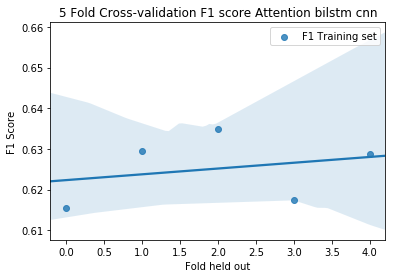

In [10]:
verbose = 100

#Model parameters
input_size = 300
hidden_dim = 300
num_layers = 2
num_channels = 70
kernel_size = 1
pool_size = 100
dropout = 0.1

epoch = 5

#Evaluation metrics for model
accuracy_fold = []
f1_fold = []
avg_error = []
preds = {i:[] for i in range(375806)}

ngpu = 1
device = torch.device("cuda: 0" if(torch.cuda.is_available() and ngpu >= 1) else "cpu")

from tqdm import tqdm
for i in tqdm(range(num_folds)): 
    try:
        Attn_bid_lstm_cnn = bidirec_lstm_cnn_attn(input_size, hidden_dim, num_layers, num_channels, kernel_size, pool_size, dropout).cuda()
    except:
        Attn_bid_lstm_cnn = bidirec_lstm_cnn_attn(input_size, hidden_dim, num_layers, num_channels, kernel_size, pool_size, dropout).cuda()

    optimizer = optim.Adam(Attn_bid_lstm_cnn.parameters())
    criterion = nn.BCELoss()
    
    train_folds = []
    
    for j in range(num_folds): 
        if j != i:
            train_folds.append(train_fold_loader[j])
        else: 
            val_fold = train_fold_loader[j]
    Attn_bid_lstm_cnn.train()
    print('++++++++++++++++++++++++++++++++++++++++')
    print('Fold -> {}'.format(i))
    for e in range(1, epoch+1):
        total_error = 0
        num = 0
        np.random.shuffle(train_folds)
        for fold in train_folds:
            for batch in fold:
                loss = train_model(batch)
                total_error += loss
                torch.cuda.empty_cache()
            num += 1
            torch.cuda.empty_cache()
        avg_loss = total_error/(len(train_folds)*len(train_folds[0]))
        print('\tEpoch {}/5\tAVG loss: {}\tTotal loss:{}'.format(e, avg_loss, total_error))
        torch.cuda.empty_cache()
        avg_error.append(avg_loss)
    Attn_bid_lstm_cnn.eval()
    acc, f = validation(val_fold, test_loader, preds)
    accuracy_fold.append(acc)
    f1_fold.append(f)
    torch.cuda.empty_cache()
plot()

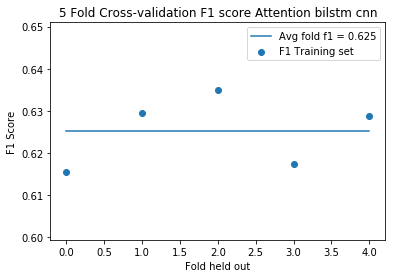

In [23]:
torch.sa

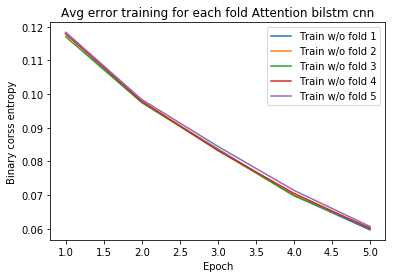

In [13]:
start = 0
end = 5
for i in range(5):
    plt.plot([i for i in range(1,6)], avg_error[start:end], label = 'Train w/o fold {}'.format(i+1))
    start = end
    end+=5
plt.title('Avg error training for each fold Attention bilstm cnn')
plt.legend()
plt.ylabel('Binary corss entropy')
plt.xlabel('Epoch')
plt.show()

In [24]:
with open('result_bilstm_cnn_attention.txt', mode = 'w') as f: 
    for key in preds.keys():
        f.write(str(key))
        for val in preds[key]:
            f.write(' {}'.format(str(val)))
        f.write('\n')

In [ ]:
predictions = {}
for key in preds.keys(): 
    threshold = 0.4
    temp = []
    for val in preds[key]:
        temp.append(val > threshold)
    temp = sum(temp)
    if temp > 1: 
        predictions[key] = 1
    else:
        predictions[key] = 0
predictions = sorted(predictions.items())

In [ ]:
predictions = [x[1] for x in predictions]
qid = pd.read_csv('qid.csv')
sub = {'qid':list(qid.qid), 'prediction':predictions}
submission_ = pd.DataFrame.from_dict(sub)

In [ ]:
actual = pd.read_csv('submission.csv')
flagged = submission_[submission_.prediction == 1]
act_flagged = actual[actual.prediction == 1]
found = 0
for i in act_flagged.index: 
    if submission_.prediction.iloc[i] == 1:
        found += 1
print(found)
print(len(flagged))

In [ ]:
with open('preds_attn_lstm_cnn_0134.txt', mode = 'w') as f: 
    f.write('import pandas as pd \n')
    f.write('pred = [')
    count = 0
    written = 0
    #replace data -> pd dataframe
    for ind in submission_.index: 
        if count < 40:
            if submission_.prediction.iloc[ind]:
                f.write('{},'.format(1))
            else: 
                f.write('{},'.format(0))
            count += 1
            written += 1
        else: 
            f.write('\n')
            if submission_.prediction.iloc[ind]:
                f.write('{},'.format(1))
            else: 
                f.write('{},'.format(0))
            count = 0
            written += 1
    f.write(']\n')
    f.write('test = pd.read_csv(\'../input/test.csv\').qid\n')
    f.write('sub = {\'qid\':[], \'prediction\':[]}\n')

    f.write('for i in range(len(pred)):\n')
    f.write('\tsub[\'qid\'].append(test.iloc[i])\n')
    f.write('\tsub[\'prediction\'].append(pred[i])\n')
    f.write('sub = pd.DataFrame.from_dict(sub)\n')
    f.write('sub.to_csv(\'submission.csv\', index=False)')